In [0]:
#data analysis libraries 
import numpy as np
import pandas as pd

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(r"/Users/ben/Documents/kaggle/incarcerated_survey-master/data/incarcerated_survey_responses-marshallproject_slate-march_2019.csv")

# Preliminary Data Exploration

This dataset was originally created by The Marshall Project in which they did a wide-scale political survey on prison inmates in the United States.
The github link can be found here: https://github.com/themarshallproject/incarcerated_survey

The entirety of the dataset consists of survey responses. It is almost entirely categorical data with a small contingent of binar category data near the bottom. A lot of features that should have been much more granular are vastly oversimplified (most likely for the ease of answering for the respondents of the survey) such as age, years in prison, amongst others.

The following information taken directly from the GitHub page for this dataset. It is meant to help explain the features shown below:

age Age group of the respondent: 35 or younger, 36 or older, NA if not given by respondent or withheld for privacy reasons

identifies_as_man Whether respondent identified as a man: TRUE, FALSE, NA if withheld

identifies_as_woman Whether respondent identified as a woman: TRUE, FALSE, NA if withheld

identifies_as_hispanic_or_latinx Whether respondent identified their ethnicity as Hispanic or Latino/a: TRUE, FALSE, NA if withheld

identifies_as_black Whether respondent identified their race as black: TRUE, FALSE, NA if withheld

identifies_as_white Whether respondent identified their race as white: TRUE, FALSE, NA if withheld

highest_education_level Respondent's highest level of education: High school or GED or less, Trade/technical/vocational training, Associate degree, college degree, or more, NA if not given or withheld

length_in_this_facility How long respondent has been incarcerated in their current facility: 10 years or less, Over 10 years, NA if not given or withheld

state State of the facility where respondent is incarcerated: either state abbreviation, NA if not given or withheld

party Political party respondent identified as belonging to: The Republican party, The Democratic party, Independent, NA if not given or withheld

Columns of the form cj_important_issue_... Responses to question Please pick the top three most important criminal justice issues for the next president: ... for several given issues, 1 if respondent marked given reason as one of the top issues, 0 if not. Refer to questions descriptions in data/incarcerated_survey_questions-marshallproject_slate-march_2019.csv for details

all other columns Responses to the rest of the survey political questions, refer to questions descriptions in data/incarcerated_survey_questions-marshallproject_slate-march_2019.csv for details

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8266 entries, 0 to 8265
Data columns (total 37 columns):
 #   Column                                                             Non-Null Count  Dtype 
---  ------                                                             --------------  ----- 
 0   age                                                                5618 non-null   object
 1   identifies_as_man                                                  6240 non-null   object
 2   identifies_as_woman                                                6240 non-null   object
 3   identifies_as_hispanic_or_latinx                                   6240 non-null   object
 4   identifies_as_black                                                6240 non-null   object
 5   identifies_as_white                                                6240 non-null   object
 6   highest_education_level                                            5618 non-null   object
 7   length_in_this_facility          

In [0]:
(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)

state                                                                0.644810
age                                                                  0.320348
highest_education_level                                              0.320348
length_in_this_facility                                              0.320348
identifies_as_man                                                    0.245100
identifies_as_woman                                                  0.245100
identifies_as_hispanic_or_latinx                                     0.245100
identifies_as_black                                                  0.245100
identifies_as_white                                                  0.245100
who_vote_for                                                         0.084926
party                                                                0.078514
approve_disapprove_trump                                             0.076095
politics_changed_since_incarcerated                             

Checking target variable distribution. It seems okay.

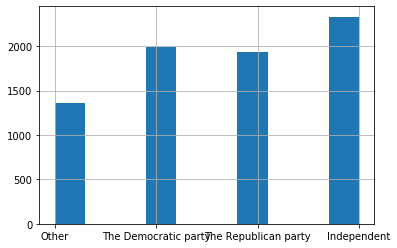

In [0]:
df['party'].hist()

# Saving the dataset to a workable variable

Also dropped the "state" column because there were simply too many datapoints missing, over half. In it's current state, I don't think it would be wise to use it and interpolating or imputing by mode may have an adverse affect on further analysis

After that, put non-numerical values into a variable in order to concat the dummies.

Before taking dummies, I decided to get rid of a few variables: how_get_news because there was simply too much variation, and other variables which I believed would be too indicative of what political party the respondent was part of (who_vote_for, approve_disapprove_trump, which_party_for_cj_reform). In other words, it would be too "on the head" to ask a person if they would vote for trump and then expect them to be a democrat.

In [0]:
test = df
test = test.drop('state', 1)
test.isnull().sum().sort_values(ascending=False)
non_numeric = test.select_dtypes('object').columns
non_numeric = non_numeric.drop(['how_get_news', 'who_vote_for', 'approve_disapprove_trump', 'party', 'which_party_for_cj_reform'])

In [0]:
test = pd.concat([test, pd.get_dummies(test[non_numeric])], axis = 1)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8266 entries, 0 to 8265
Columns: 103 entries, age to politics_changed_since_incarcerated_Yes
dtypes: int64(11), object(25), uint8(67)
memory usage: 2.8+ MB


Removing all null rows from the target feature ('party')

In [0]:
test = test[test['party'].notna()]

In [0]:
pd.set_option('display.max_rows', None)
test.isnull().sum().sort_values(ascending=False)

age                                                                                                       1999
length_in_this_facility                                                                                   1999
identifies_as_man                                                                                         1999
identifies_as_woman                                                                                       1999
identifies_as_hispanic_or_latinx                                                                          1999
identifies_as_black                                                                                       1999
identifies_as_white                                                                                       1999
highest_education_level                                                                                   1999
who_vote_for                                                                                                82
w

Here, I decided to combine "other" and "independent" simply because there is too much variation in the two groups that is severely disrupts any kind of classifier model accuracy. I will include a small part at the bottom which proves how leaving "Other" and "indepdendent" in the dataset can cause accuracy problems. 

In order to solve the problem, I simply folded all non major-party groups into "independent" as they are already independently voting for people without paying heed to the two major parties.

Now that I think of it, it may have been more prudent to fold "Independent" into "Other" as that is essentially the category I was creating..

In [0]:
test['party_filter'] = test['party'].replace(['Other'], ['Independent'])

In [0]:
test['party_filter'].value_counts()

Independent             3688
The Democratic party    1995
The Republican party    1934
Name: party_filter, dtype: int64

At this point, I decided to integer-encode the target feature to make it work with the models a little better.

In [0]:
test['party_y'] = test['party_filter'].replace(['Independent', 'The Democratic party',
       'The Republican party'], [3, 1, 2])

In [0]:
numeric_rows = test.select_dtypes(['int64', 'uint8']).columns
numeric_rows = numeric_rows.drop(['party_y'], 1)

Checking the overall data distribution of the target feature I am going to use. It seems things have skewed slightly.

count    7617.000000
mean        2.222266
std         0.834736
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         3.000000
Name: party_y, dtype: float64

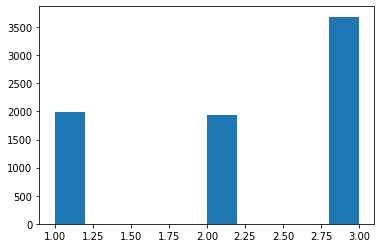

In [0]:
plt.hist(test['party_y'])

test['party_y'].describe()

This may not be necessary, but just to get a good idea of how all the variables relate to the the target feature, it may be interesting to see how the data stacks up against it. There are far too many columns to be able to reliably see everything. However, as a whole, there are a few differences in values.

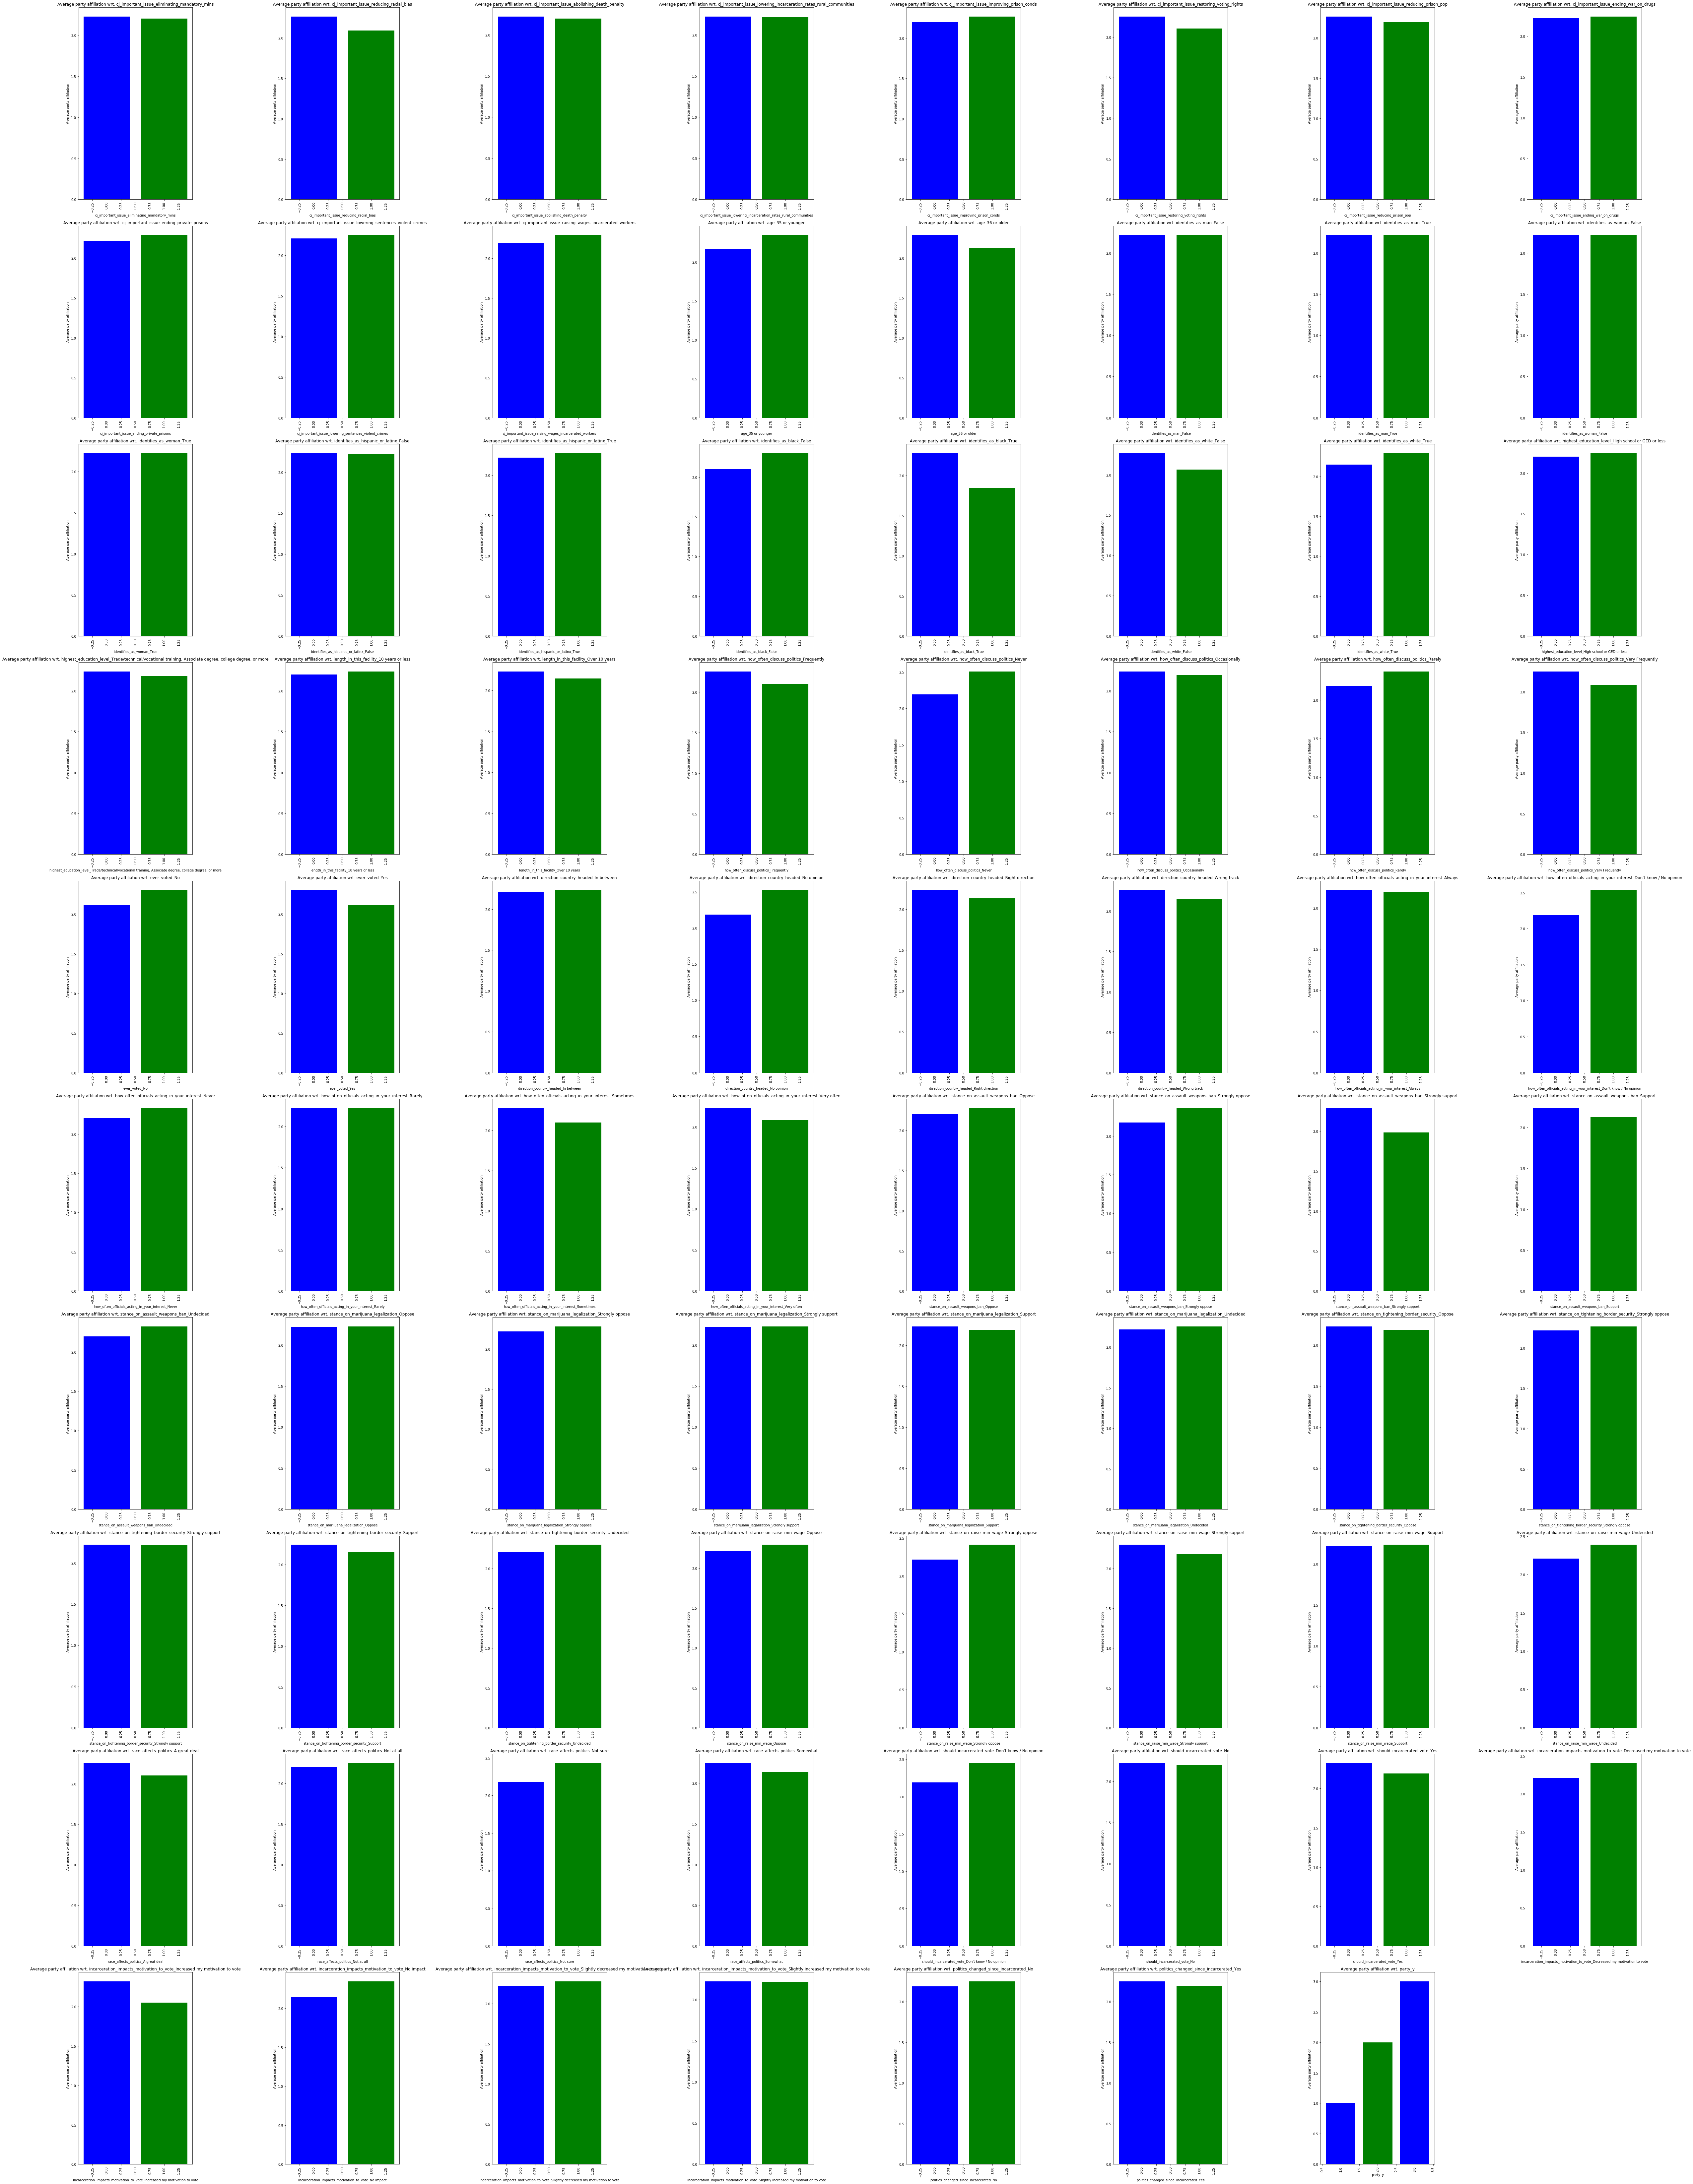

In [0]:
numeric_columns = test.select_dtypes(['int64', 'uint8']).columns

plt.figure(figsize=(70,100))

for index, column in enumerate(numeric_columns):
    plt.subplot(11,8,index+1)
    plt.bar(test.groupby(column)["party_y"].mean().index, test.groupby(column)["party_y"].mean(),
           color=("blue","green"))
    plt.title("Average party affiliation wrt. {}".format(column))
    plt.ylabel("Average party affiliation")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()


There are FAR too many columns to make a heatmap where everything is visible. However, simply judging by color (and good eyes), we can see that there are some linear correlations when it comes to identity.

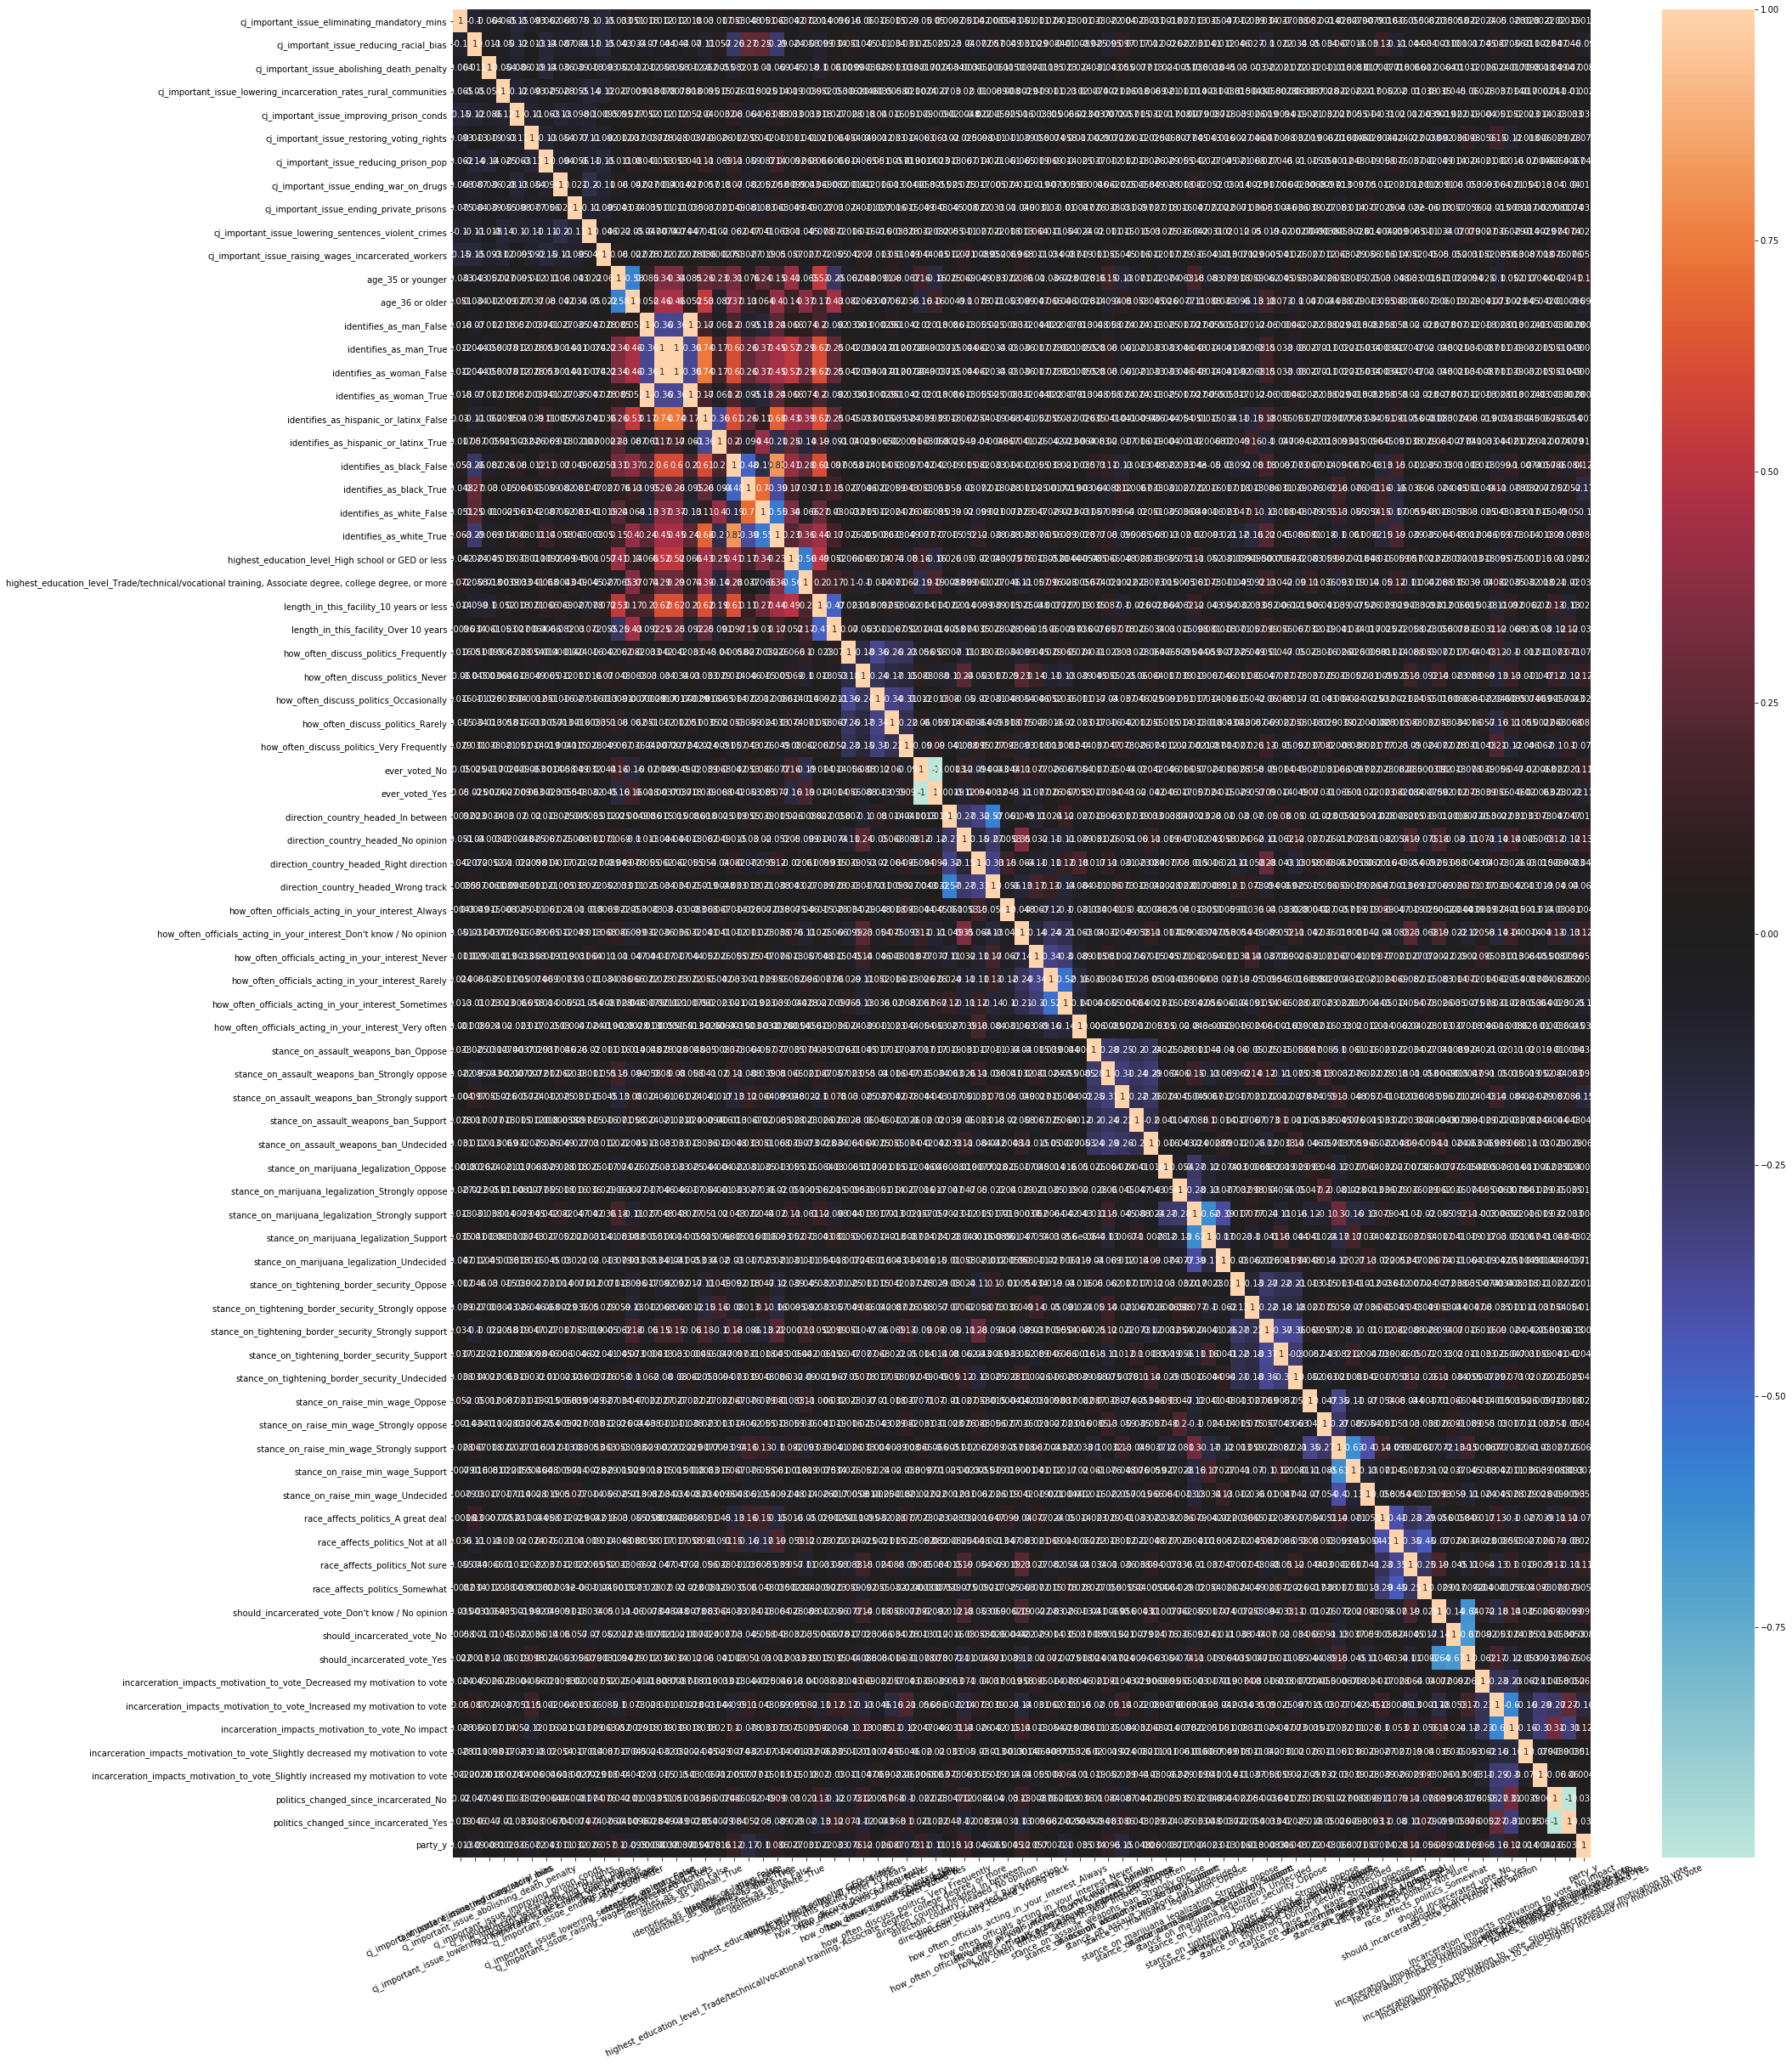

In [0]:
import seaborn as sns

plt.figure(figsize=(30, 40))
sns.heatmap(test.corr(), center=0, annot=True)
plt.xticks(rotation=25)
plt.show()

Instead of destroying my eyes looking at the above heatmap, I will focus simply on linear correlations of the target feature in relation to all the other columns. This is presented below:

In [0]:
np.abs(test.iloc[:, 1:].corr().loc[:, 'party_y']).sort_values(ascending=False)

party_y                                                                                                   1.000000
identifies_as_black_True                                                                                  0.172143
incarceration_impacts_motivation_to_vote_Increased my motivation to vote                                  0.156449
stance_on_assault_weapons_ban_Strongly support                                                            0.149956
direction_country_headed_No opinion                                                                       0.129931
how_often_officials_acting_in_your_interest_Don't know / No opinion                                       0.118329
identifies_as_black_False                                                                                 0.117944
incarceration_impacts_motivation_to_vote_No impact                                                        0.116335
how_often_discuss_politics_Never                                                

# Vanilla model analysis (no tuning done yet)

Before taking feature importance, I'm going to run the data through a series of analysis models:
LinearRegression
RandomForest
KNN
LinearSVC
XGBoost
to simply see how unchanged data does and then compare any later models to this baseline.

FIRST IS: LogisticRegression

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = test[numeric_rows]
y = test['party_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


lr = LogisticRegression(solver = 'lbfgs', max_iter = 10000)
lr.fit(X_train, y_train)

print("Training set Accuracy for logistic regression classifier = ", lr.score(X_train, y_train) )
print("Test set Accuracy for logistic regression classifier = ", lr.score(X_test, y_test) )
print("")

from sklearn import metrics

print('Training set classification report')
lr_pred_train = lr.predict(X_train)
print(metrics.classification_report(y_train, lr_pred_train))

print('------------')

print('Test set classification report')
lr_pred_test = lr.predict(X_test)
print(metrics.classification_report(y_test, lr_pred_test))

Training set Accuracy for logistic regression classifier =  0.6054488757590678
Test set Accuracy for logistic regression classifier =  0.6030183727034121

Training set classification report
              precision    recall  f1-score   support

           1       0.58      0.41      0.48      1599
           2       0.62      0.53      0.57      1540
           3       0.61      0.75      0.67      2954

    accuracy                           0.61      6093
   macro avg       0.60      0.56      0.57      6093
weighted avg       0.60      0.61      0.60      6093

------------
Test set classification report
              precision    recall  f1-score   support

           1       0.59      0.41      0.48       396
           2       0.64      0.51      0.57       394
           3       0.60      0.76      0.67       734

    accuracy                           0.60      1524
   macro avg       0.61      0.56      0.57      1524
weighted avg       0.60      0.60      0.59      1524



Training set Confusion Matrix
-----------------------------
Test set Confusion Matrix


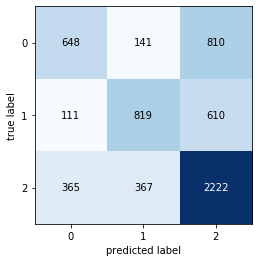

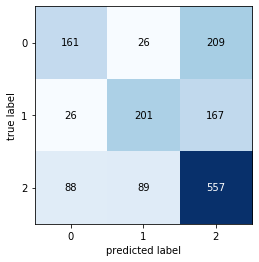

In [0]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

print('Training set Confusion Matrix')
print("-----------------------------")
print('Test set Confusion Matrix')

lr_cnf = confusion_matrix(y_train, lr_pred_train)
fig, ax = plot_confusion_matrix(conf_mat = lr_cnf)

lr_cnf = confusion_matrix(y_test, lr_pred_test)
fig, ax = plot_confusion_matrix(conf_mat = lr_cnf)

OOPS - This may be a little late, but these are the dummy classifiers

In [0]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy = 'uniform')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train), dummy.score(X_test, y_test)

(0.3408829804693911, 0.3228346456692913)

Next vanilla model: RandomForest

In [0]:
from sklearn.ensemble import RandomForestClassifier

from sklearn import ensemble
from sklearn.metrics import confusion_matrix, precision_score, recall_score

rf = RandomForestClassifier(max_depth = 5)
rf.fit(X_train, y_train)
print("Accuracy Training set for RandomForest regression classifier = ", rf.score(X_train, y_train) )
print("Accuracy Test set for RandomForest regression classifier = ", rf.score(X_test, y_test) )
print('')

from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
print(cross_val_score(rfc, X_train, y_train, cv = 5))
print(cross_val_score(rfc, X_test, y_test, cv = 5))
print('')

print('Training set classification report')
rf_pred_train = rf.predict(X_train)
print(metrics.classification_report(y_train, rf_pred_train))

print('------------')

print('Test set classification report')
rf_pred_test = rf.predict(X_test)
print(metrics.classification_report(y_test, rf_pred_test))

Accuracy Training set for RandomForest regression classifier =  0.5816510750041031
Accuracy Test set for RandomForest regression classifier =  0.5708661417322834

[0.58654635 0.56275636 0.58654635 0.56896552 0.59852217]
[0.60983607 0.59672131 0.54098361 0.59344262 0.59210526]

Training set classification report
              precision    recall  f1-score   support

           1       0.67      0.19      0.30      1599
           2       0.70      0.39      0.50      1540
           3       0.55      0.89      0.68      2954

    accuracy                           0.58      6093
   macro avg       0.64      0.49      0.49      6093
weighted avg       0.62      0.58      0.54      6093

------------
Test set classification report
              precision    recall  f1-score   support

           1       0.66      0.17      0.27       396
           2       0.71      0.36      0.48       394
           3       0.54      0.90      0.68       734

    accuracy                           0.57 

Training set Confusion Matrix
-----------------------------
Test set Confusion Matrix


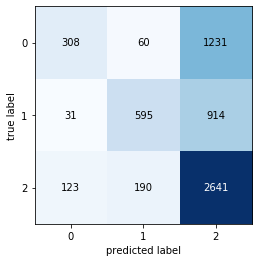

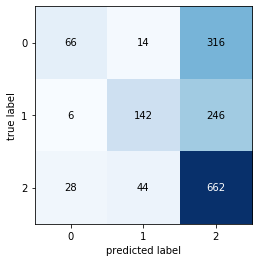

In [0]:
print('Training set Confusion Matrix')
print("-----------------------------")
print('Test set Confusion Matrix')

rf_cnf = confusion_matrix(y_train, rf_pred_train)
fig, ax = plot_confusion_matrix(conf_mat = rf_cnf)

rf_cnf = confusion_matrix(y_test, rf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat = rf_cnf)

Next: KNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

print("Accuracy for Training set of KNN regression classifier = ", knn.score(X_train, y_train) )
print("Accuracy for Test set of KNN regression classifier = ", knn.score(X_test, y_test) )
print('')
knn_pred_train = knn.predict(X_train)
knn_pred_test = knn.predict(X_test)

print('Training set classification report')
print(metrics.classification_report(y_train, knn_pred_train))
print('------------')

print('Test set classification report')
print(metrics.classification_report(y_test, knn_pred_test))

#Overfitting
#Tuning hyperparameters

Accuracy for Training set of KNN regression classifier =  0.6674872804858034
Accuracy for Test set of KNN regression classifier =  0.5223097112860893

Training set classification report
              precision    recall  f1-score   support

           1       0.58      0.62      0.60      1599
           2       0.64      0.65      0.64      1540
           3       0.74      0.70      0.72      2954

    accuracy                           0.67      6093
   macro avg       0.65      0.66      0.65      6093
weighted avg       0.67      0.67      0.67      6093

------------
Test set classification report
              precision    recall  f1-score   support

           1       0.44      0.44      0.44       396
           2       0.49      0.53      0.50       394
           3       0.59      0.56      0.58       734

    accuracy                           0.52      1524
   macro avg       0.51      0.51      0.51      1524
weighted avg       0.53      0.52      0.52      1524



Training set Confusion Matrix
-----------------------------
Test set Confusion Matrix


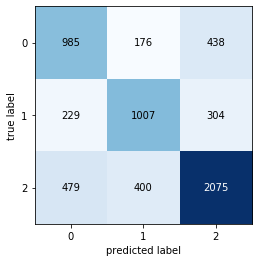

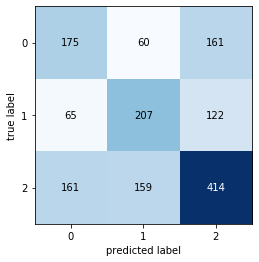

In [0]:
print('Training set Confusion Matrix')
print("-----------------------------")
print('Test set Confusion Matrix')

knn_cnf = confusion_matrix(y_train, knn_pred_train)
fig, ax = plot_confusion_matrix(conf_mat = knn_cnf)

knn_cnf = confusion_matrix(y_test, knn_pred_test)
fig, ax = plot_confusion_matrix(conf_mat = knn_cnf)

Next: LinearSVC

In [0]:
from sklearn.svm import LinearSVC
svm = LinearSVC(penalty='l1', dual=False)

svm.fit(X_train, y_train)

print("Accuracy for Training Set of SVM classifier = ", svm.score(X_train, y_train) )
print("Accuracy for Test Set of SVM classifier = ", svm.score(X_test, y_test) )
print('')
svm_pred_train = svm.predict(X_train)
svm_pred_test = svm.predict(X_test)

print('Training set classification report')
print(metrics.classification_report(y_train, svm_pred_train))
print('------------')

print('Test set classification report')
print(metrics.classification_report(y_test, svm_pred_test))

Accuracy for Training Set of SVM classifier =  0.6010175611357296
Accuracy for Test Set of SVM classifier =  0.6003937007874016

Training set classification report
              precision    recall  f1-score   support

           1       0.57      0.38      0.45      1599
           2       0.61      0.54      0.57      1540
           3       0.61      0.76      0.67      2954

    accuracy                           0.60      6093
   macro avg       0.60      0.56      0.57      6093
weighted avg       0.60      0.60      0.59      6093

------------
Test set classification report
              precision    recall  f1-score   support

           1       0.59      0.38      0.46       396
           2       0.63      0.51      0.56       394
           3       0.60      0.77      0.67       734

    accuracy                           0.60      1524
   macro avg       0.60      0.55      0.57      1524
weighted avg       0.60      0.60      0.59      1524



Training set Confusion Matrix
-----------------------------
Test set Confusion Matrix


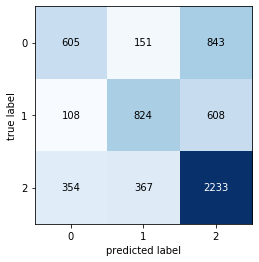

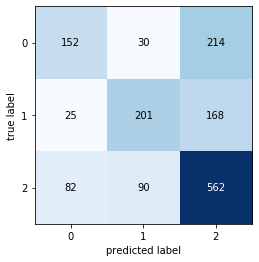

In [0]:
print('Training set Confusion Matrix')
print("-----------------------------")
print('Test set Confusion Matrix')

svm_cnf = confusion_matrix(y_train, svm_pred_train)
fig, ax = plot_confusion_matrix(conf_mat = svm_cnf)

svm_cnf = confusion_matrix(y_test, svm_pred_test)
fig, ax = plot_confusion_matrix(conf_mat = svm_cnf)

Finally: XGBoost

In [0]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
print("Accuracy for Training Set of XGBoost classifier = ", xgb.score(X_train, y_train) )
print("Accuracy for Test Set of XGBoost classifier = ", xgb.score(X_test, y_test) )
print('')
xgb_pred_train = xgb.predict(X_train)
xgb_pred_test = xgb.predict(X_test)

print('Training set classification report')
print(metrics.classification_report(y_train, xgb_pred_train))
print('------------')

print('Test set classification report')
print(metrics.classification_report(y_test, xgb_pred_test))

#Overfitting

Accuracy for Training Set of XGBoost classifier =  0.9571639586410635
Accuracy for Test Set of XGBoost classifier =  0.5767716535433071

Training set classification report
              precision    recall  f1-score   support

           1       0.97      0.94      0.95      1599
           2       0.95      0.94      0.95      1540
           3       0.95      0.97      0.96      2954

    accuracy                           0.96      6093
   macro avg       0.96      0.95      0.96      6093
weighted avg       0.96      0.96      0.96      6093

------------
Test set classification report
              precision    recall  f1-score   support

           1       0.52      0.42      0.47       396
           2       0.57      0.49      0.53       394
           3       0.60      0.71      0.65       734

    accuracy                           0.58      1524
   macro avg       0.56      0.54      0.55      1524
weighted avg       0.57      0.58      0.57      1524



Training set Confusion Matrix
-----------------------------
Test set Confusion Matrix


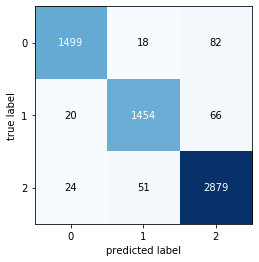

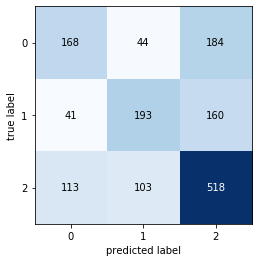

In [0]:
print('Training set Confusion Matrix')
print("-----------------------------")
print('Test set Confusion Matrix')

xgb_cnf = confusion_matrix(y_train, xgb_pred_train)
fig, ax = plot_confusion_matrix(conf_mat = xgb_cnf)

xgb_cnf = confusion_matrix(y_test, xgb_pred_test)
fig, ax = plot_confusion_matrix(conf_mat = xgb_cnf)

Just a quick summary of our vanilla models:

Linear Regression:
Training set Accuracy for logistic regression classifier =  0.6054488757590678 //
Test set Accuracy for logistic regression classifier =  0.6030183727034121

RandomForest: Accuracy Training set for RandomForest regression classifier =  0.5816510750041031 //
Accuracy Test set for RandomForest regression classifier =  0.5708661417322834

KNN:
Accuracy for Training set of KNN regression classifier =  0.6674872804858034 //
Accuracy for Test set of KNN regression classifier =  0.5223097112860893

SVM:
Accuracy for Training Set of SVM classifier =  0.6010175611357296 //
Accuracy for Test Set of SVM classifier =  0.6003937007874016

XGBoost:
Accuracy for Training Set of XGBoost classifier =  0.9571639586410635 //
Accuracy for Test Set of XGBoost classifier =  0.5767716535433071


There seems to be some serious discrepancy between training and test set scores on KNN and XGBoost. However, just looking at how the models are performing, I think I'm going to disclude KNN from hyperparameter tuning later on in this analysis.

# Feature Importance and cutting out less important features

I decided to use a DecisionTreeClassifier to check for feature importance, but I also double checked importance with an ExtraTreesClassifier

In [0]:
X = test[numeric_rows]
y = test['party_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=500)
%time dtc.fit(X, y)
print(sorted(zip(dtc.feature_importances_, X.columns), reverse=True))

CPU times: user 69.3 ms, sys: 2.41 ms, total: 71.7 ms
Wall time: 71.9 ms
[(0.052558039317673166, 'stance_on_tightening_border_security_Strongly support'), (0.026348301674404943, 'direction_country_headed_Right direction'), (0.024088162410903106, 'identifies_as_black_True'), (0.023690754434010843, 'cj_important_issue_improving_prison_conds'), (0.02211910938740982, 'cj_important_issue_reducing_prison_pop'), (0.021995327048374466, 'cj_important_issue_raising_wages_incarcerated_workers'), (0.02153432203491578, 'cj_important_issue_eliminating_mandatory_mins'), (0.021112121767522356, 'cj_important_issue_lowering_incarceration_rates_rural_communities'), (0.020765013602788433, 'cj_important_issue_restoring_voting_rights'), (0.02061677417203762, 'how_often_discuss_politics_Rarely'), (0.01975875106199461, 'cj_important_issue_lowering_sentences_violent_crimes'), (0.019277507343828593, 'how_often_officials_acting_in_your_interest_Sometimes'), (0.019054094624442422, 'cj_important_issue_reducing_rac

[0.02006205 0.01666887 0.01038946 0.01560602 0.02008518 0.0172083
 0.02177654 0.01600019 0.01313904 0.02053317 0.01903572 0.01151539
 0.01277567 0.0031684  0.0056247  0.00520054 0.00339579 0.00530993
 0.00341351 0.00959387 0.00976144 0.01029494 0.01045091 0.0124269
 0.01197724 0.00919492 0.00769447 0.01585666 0.00987054 0.01816744
 0.01442947 0.01412162 0.01398893 0.01421478 0.01570512 0.01021465
 0.03056892 0.01669432 0.00383244 0.00851481 0.01258015 0.01775994
 0.0182148  0.00619188 0.01330622 0.01514493 0.01717662 0.01322873
 0.01263538 0.00651263 0.00652951 0.01822751 0.01428356 0.00926204
 0.01087554 0.00853143 0.03023893 0.0136895  0.01446983 0.0065933
 0.00368967 0.0162573  0.01175126 0.00680505 0.01475615 0.01759384
 0.01264275 0.0164274  0.00896702 0.01065793 0.01356746 0.00778271
 0.01824481 0.0165291  0.00564483 0.01150203 0.01634537 0.0169    ]


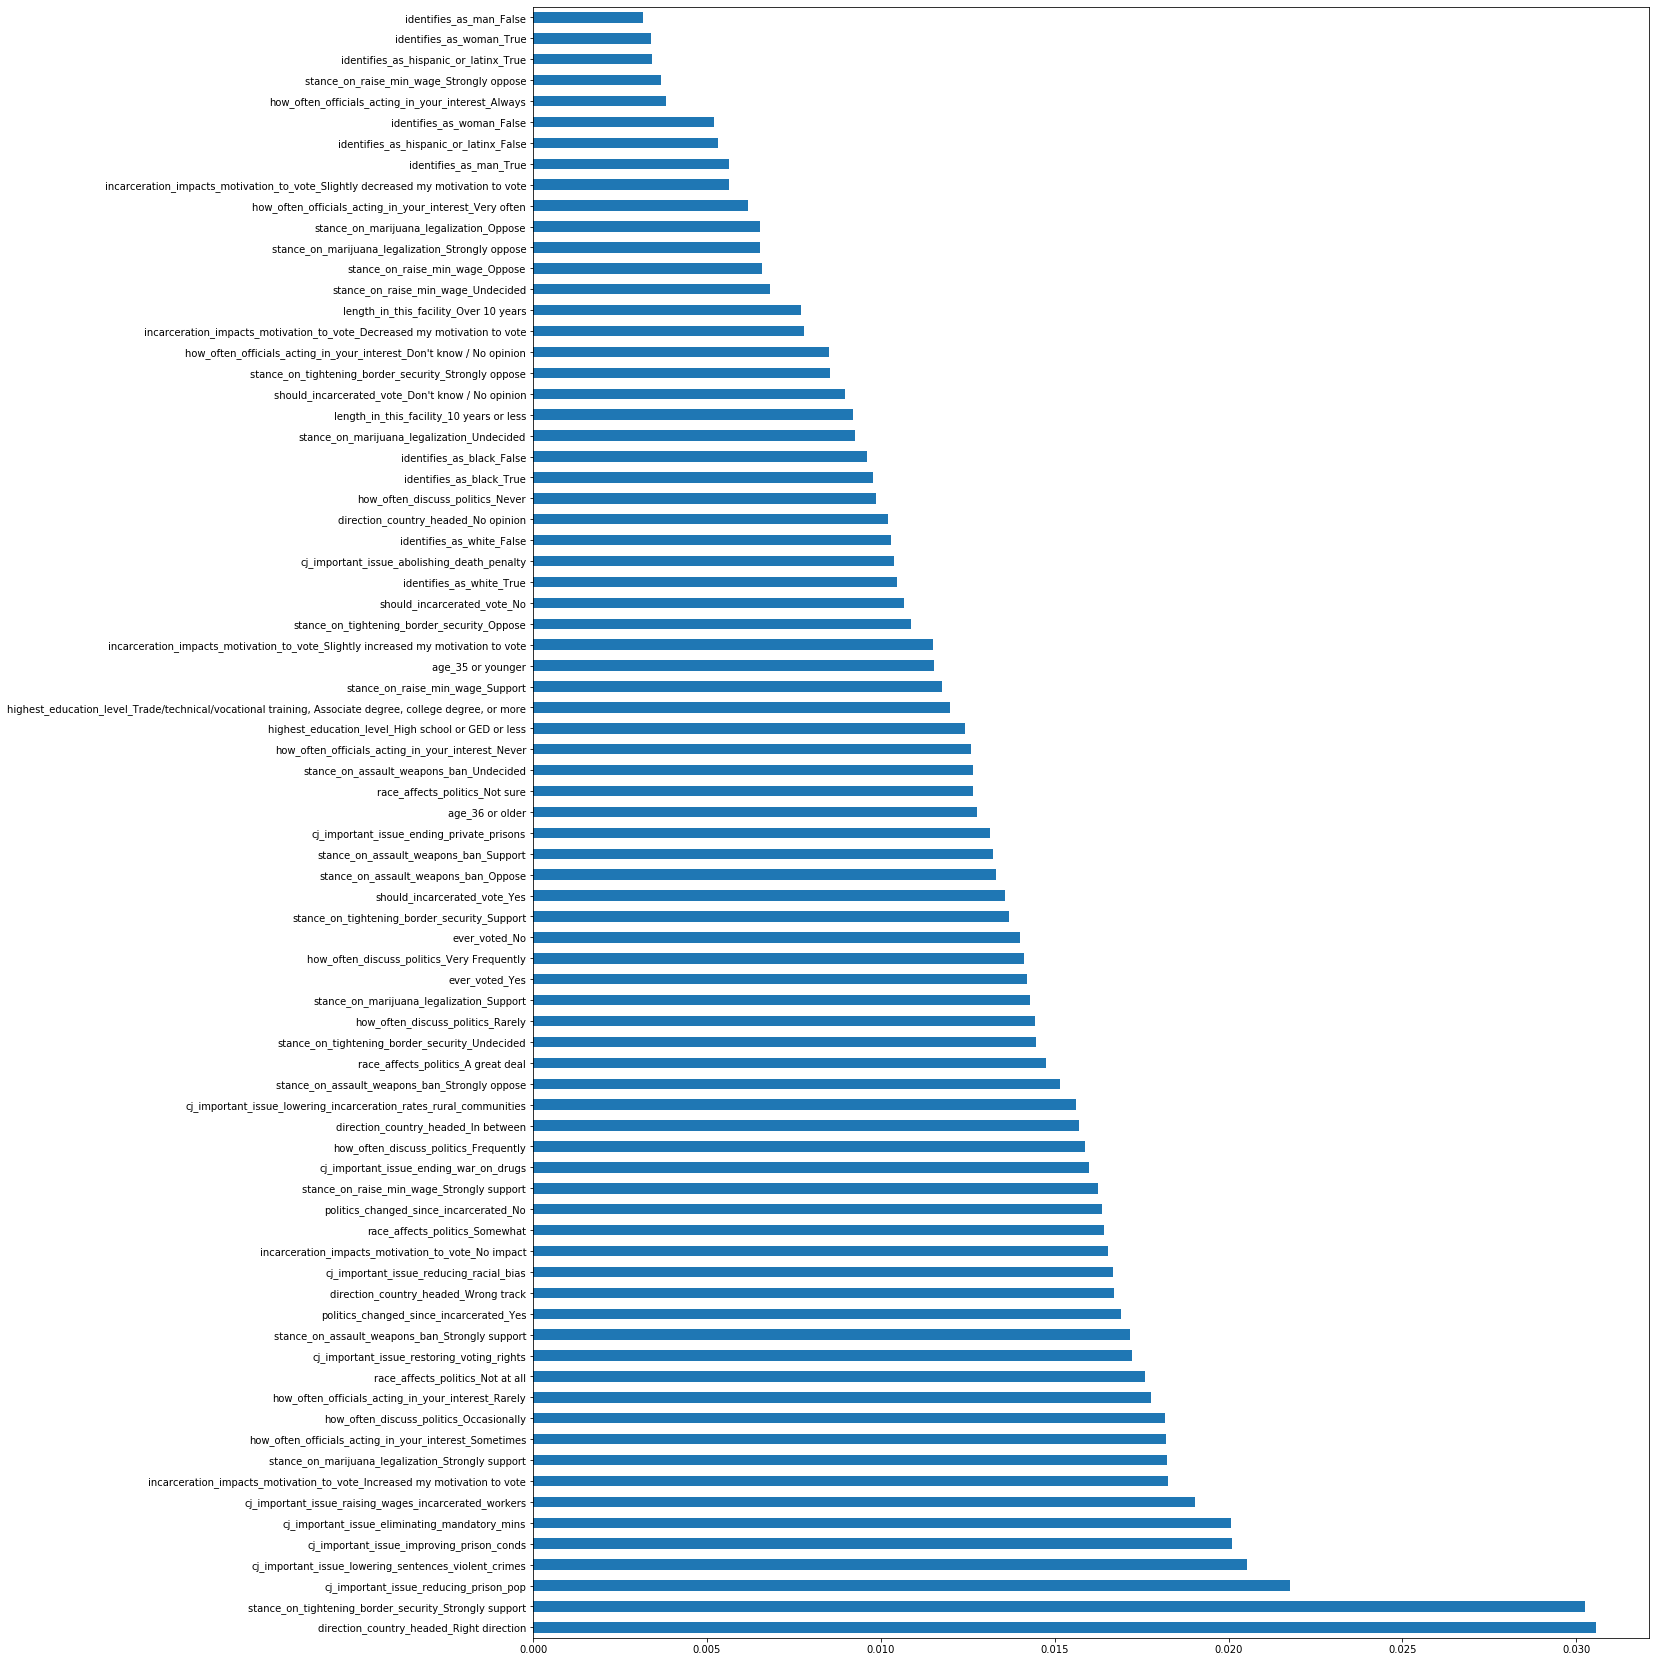

In [0]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X_train, y_train)
print(model.feature_importances_)

plt.figure(figsize=(20,30))
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.nlargest(100).plot(kind='barh')
plt.show()

It seems like the two models are displaying more or less the same information

In [0]:
f_import = sorted(zip(dtc.feature_importances_, X.columns))
high_import = []

for item in f_import:
    if item[0] > 0.009:
        high_import.append(item[1])

I decided to take features with an importance higher than 0.009. 

In [0]:
X = test[high_import]
y = test['party_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Re-running after cutting out less important features

In [0]:
lr = LogisticRegression(penalty = 'l1', solver = 'liblinear', max_iter = 1000)
lr.fit(X_train, y_train)

print("Training set Accuracy for logistic regression classifier = ", lr.score(X_train, y_train) )
print("Test set Accuracy for logistic regression classifier = ", lr.score(X_test, y_test) )
print("")

from sklearn import metrics

print('Training set classification report')
lr_pred_train = lr.predict(X_train)
print(metrics.classification_report(y_train, lr_pred_train))

print('------------')

print('Test set classification report')
lr_pred_test = lr.predict(X_test)
print(metrics.classification_report(y_test, lr_pred_test))

Training set Accuracy for logistic regression classifier =  0.6010175611357296
Test set Accuracy for logistic regression classifier =  0.5853018372703412

Training set classification report
              precision    recall  f1-score   support

           1       0.57      0.38      0.46      1612
           2       0.61      0.53      0.57      1522
           3       0.61      0.76      0.67      2959

    accuracy                           0.60      6093
   macro avg       0.60      0.56      0.57      6093
weighted avg       0.60      0.60      0.59      6093

------------
Test set classification report
              precision    recall  f1-score   support

           1       0.55      0.38      0.45       383
           2       0.60      0.51      0.55       412
           3       0.59      0.74      0.66       729

    accuracy                           0.59      1524
   macro avg       0.58      0.54      0.55      1524
weighted avg       0.58      0.59      0.57      1524



Training set Confusion Matrix
-----------------------------
Test set Confusion Matrix


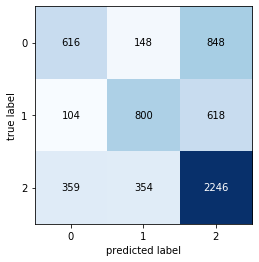

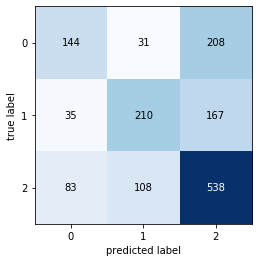

In [0]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

print('Training set Confusion Matrix')
print("-----------------------------")
print('Test set Confusion Matrix')

lr_cnf = confusion_matrix(y_train, lr_pred_train)
fig, ax = plot_confusion_matrix(conf_mat = lr_cnf)

lr_cnf = confusion_matrix(y_test, lr_pred_test)
fig, ax = plot_confusion_matrix(conf_mat = lr_cnf)

In [0]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print("Accuracy Training set for RandomForest regression classifier = ", rf.score(X_train, y_train) )
print("Accuracy Test set for RandomForest regression classifier = ", rf.score(X_test, y_test) )
print('')

rfc = ensemble.RandomForestClassifier()
print(cross_val_score(rfc, X_train, y_train, cv = 5))
print(cross_val_score(rfc, X_test, y_test, cv = 5))
print('')

print('Training set classification report')
rf_pred_train = rf.predict(X_train)
print(metrics.classification_report(y_train, rf_pred_train))

print('------------')

print('Test set classification report')
rf_pred_test = rf.predict(X_test)
print(metrics.classification_report(y_test, rf_pred_test))

#overfitting, but can be dealt with later.
#model showing slightly better performance than above vanilla model

Accuracy Training set for RandomForest regression classifier =  1.0
Accuracy Test set for RandomForest regression classifier =  0.5912073490813649

[0.57424118 0.57178015 0.58654635 0.5591133  0.60673235]
[0.51803279 0.54754098 0.54754098 0.5704918  0.52631579]

Training set classification report
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1612
           2       1.00      1.00      1.00      1522
           3       1.00      1.00      1.00      2959

    accuracy                           1.00      6093
   macro avg       1.00      1.00      1.00      6093
weighted avg       1.00      1.00      1.00      6093

------------
Test set classification report
              precision    recall  f1-score   support

           1       0.56      0.38      0.45       383
           2       0.62      0.48      0.54       412
           3       0.59      0.77      0.67       729

    accuracy                           0.59      1524
   ma

Training set Confusion Matrix
-----------------------------
Test set Confusion Matrix


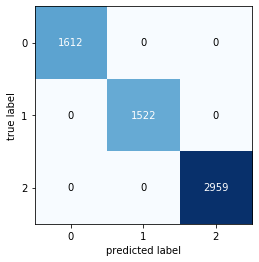

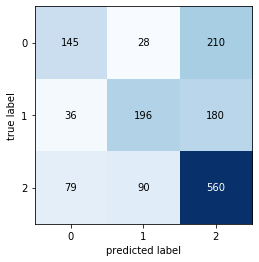

In [0]:
print('Training set Confusion Matrix')
print("-----------------------------")
print('Test set Confusion Matrix')

rf_cnf = confusion_matrix(y_train, rf_pred_train)
fig, ax = plot_confusion_matrix(conf_mat = rf_cnf)

rf_cnf = confusion_matrix(y_test, rf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat = rf_cnf)

In [0]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

print("Accuracy for Training set of KNN regression classifier = ", knn.score(X_train, y_train) )
print("Accuracy for Test set of KNN regression classifier = ", knn.score(X_test, y_test) )
print('')
knn_pred_train = knn.predict(X_train)
knn_pred_test = knn.predict(X_test)

print('Training set classification report')
print(metrics.classification_report(y_train, knn_pred_train))
print('------------')

print('Test set classification report')
print(metrics.classification_report(y_test, knn_pred_test))

Accuracy for Training set of KNN regression classifier =  0.6719185951091416
Accuracy for Test set of KNN regression classifier =  0.5013123359580053

Training set classification report
              precision    recall  f1-score   support

           1       0.60      0.63      0.61      1612
           2       0.63      0.60      0.62      1522
           3       0.73      0.73      0.73      2959

    accuracy                           0.67      6093
   macro avg       0.65      0.65      0.65      6093
weighted avg       0.67      0.67      0.67      6093

------------
Test set classification report
              precision    recall  f1-score   support

           1       0.38      0.44      0.40       383
           2       0.50      0.44      0.47       412
           3       0.58      0.57      0.57       729

    accuracy                           0.50      1524
   macro avg       0.49      0.48      0.48      1524
weighted avg       0.51      0.50      0.50      1524



Training set Confusion Matrix
-----------------------------
Test set Confusion Matrix


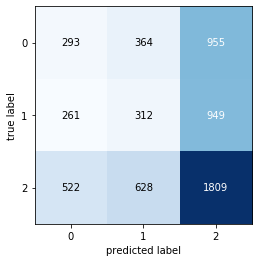

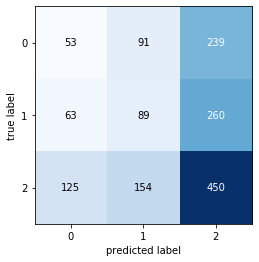

In [0]:
print('Training set Confusion Matrix')
print("-----------------------------")
print('Test set Confusion Matrix')

svm_cnf = confusion_matrix(y_train, svm_pred_train)
fig, ax = plot_confusion_matrix(conf_mat = svm_cnf)

svm_cnf = confusion_matrix(y_test, svm_pred_test)
fig, ax = plot_confusion_matrix(conf_mat = svm_cnf)

In [0]:
svm = LinearSVC(penalty='l1', dual=False)

svm.fit(X_train, y_train)

print("Accuracy for Training Set of SVM classifier = ", svm.score(X_train, y_train) )
print("Accuracy for Test Set of SVM classifier = ", svm.score(X_test, y_test) )
print('')
svm_pred_train = svm.predict(X_train)
svm_pred_test = svm.predict(X_test)

print('Training set classification report')
print(metrics.classification_report(y_train, svm_pred_train))
print('------------')

print('Test set classification report')
print(metrics.classification_report(y_test, svm_pred_test))

Accuracy for Training Set of SVM classifier =  0.6001969473165928
Accuracy for Test Set of SVM classifier =  0.583989501312336

Training set classification report
              precision    recall  f1-score   support

           1       0.57      0.37      0.45      1612
           2       0.61      0.53      0.57      1522
           3       0.60      0.76      0.67      2959

    accuracy                           0.60      6093
   macro avg       0.60      0.55      0.56      6093
weighted avg       0.60      0.60      0.59      6093

------------
Test set classification report
              precision    recall  f1-score   support

           1       0.56      0.36      0.44       383
           2       0.60      0.51      0.55       412
           3       0.59      0.74      0.66       729

    accuracy                           0.58      1524
   macro avg       0.58      0.54      0.55      1524
weighted avg       0.58      0.58      0.57      1524



Training set Confusion Matrix
-----------------------------
Test set Confusion Matrix


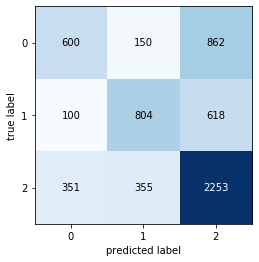

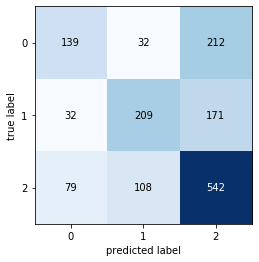

In [0]:
print('Training set Confusion Matrix')
print("-----------------------------")
print('Test set Confusion Matrix')

svm_cnf = confusion_matrix(y_train, svm_pred_train)
fig, ax = plot_confusion_matrix(conf_mat = svm_cnf)

svm_cnf = confusion_matrix(y_test, svm_pred_test)
fig, ax = plot_confusion_matrix(conf_mat = svm_cnf)

In [0]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
print("Accuracy for Training Set of XGBoost classifier = ", xgb.score(X_train, y_train) )
print("Accuracy for Test Set of XGBoost classifier = ", xgb.score(X_test, y_test) )
print('')
xgb_pred_train = xgb.predict(X_train)
xgb_pred_test = xgb.predict(X_test)

print('Training set classification report')
print(metrics.classification_report(y_train, xgb_pred_train))
print('------------')

print('Test set classification report')
print(metrics.classification_report(y_test, xgb_pred_test))

#Again, overfitting 

Accuracy for Training Set of XGBoost classifier =  0.970786148038733
Accuracy for Test Set of XGBoost classifier =  0.5498687664041995

Training set classification report
              precision    recall  f1-score   support

           1       0.98      0.95      0.97      1612
           2       0.98      0.96      0.97      1522
           3       0.96      0.99      0.97      2959

    accuracy                           0.97      6093
   macro avg       0.97      0.97      0.97      6093
weighted avg       0.97      0.97      0.97      6093

------------
Test set classification report
              precision    recall  f1-score   support

           1       0.48      0.39      0.43       383
           2       0.55      0.46      0.50       412
           3       0.57      0.68      0.62       729

    accuracy                           0.55      1524
   macro avg       0.54      0.51      0.52      1524
weighted avg       0.54      0.55      0.54      1524



Training set Confusion Matrix
-----------------------------
Test set Confusion Matrix


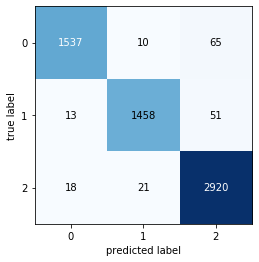

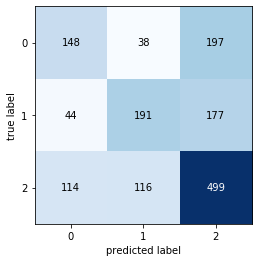

In [0]:
print('Training set Confusion Matrix')
print("-----------------------------")
print('Test set Confusion Matrix')

xgb_cnf = confusion_matrix(y_train, xgb_pred_train)
fig, ax = plot_confusion_matrix(conf_mat = xgb_cnf)

xgb_cnf = confusion_matrix(y_test, xgb_pred_test)
fig, ax = plot_confusion_matrix(conf_mat = xgb_cnf)

Just another quick recap:

VANILLA MODELS:

Just a quick summary of our vanilla models:

Linear Regression: Training set Accuracy for logistic regression classifier = 0.6054488757590678 // Test set Accuracy for logistic regression classifier = 0.6030183727034121

RandomForest: Accuracy Training set for RandomForest regression classifier = 0.5816510750041031 // Accuracy Test set for RandomForest regression classifier = 0.5708661417322834

KNN: Accuracy for Training set of KNN regression classifier = 0.6674872804858034 // Accuracy for Test set of KNN regression classifier = 0.5223097112860893

SVM: Accuracy for Training Set of SVM classifier = 0.6010175611357296 // Accuracy for Test Set of SVM classifier = 0.6003937007874016

XGBoost: Accuracy for Training Set of XGBoost classifier = 0.9571639586410635 // Accuracy for Test Set of XGBoost classifier = 0.5767716535433071



FEATURE IMPORTANCE DROPPED:

LinearRegression:
Training set Accuracy for logistic regression classifier =  0.6010175611357296 //
Test set Accuracy for logistic regression classifier =  0.5853018372703412

RandomForest:
Accuracy Training set for RandomForest regression classifier =  1.0 //
Accuracy Test set for RandomForest regression classifier =  0.5912073490813649

KNN:
Accuracy for Training set of KNN regression classifier =  0.6719185951091416 //
Accuracy for Test set of KNN regression classifier =  0.5013123359580053

SVM:
Accuracy for Training Set of SVM classifier =  0.6001969473165928 //
Accuracy for Test Set of SVM classifier =  0.583989501312336


XGBoost:
Accuracy for Training Set of XGBoost classifier =  0.970786148038733 //
Accuracy for Test Set of XGBoost classifier =  0.5498687664041995


After getting rid of any features (including dummies) which scored less than 0.09 on with a DecisionTreesClassifier, there was a slight dip in scores across the board. RandomForest is an exception though. This anomaly could be be explained by the data not reacting well to the current train/test split.

This data may not make much of a difference for LinearRegression as l1 penalty will already weight coefficients enough to neutralize any non-important features.

The overall drop (except for RandomForest) seems to be within acceptable parameters except for XGBoost, but I will be checking hyperparamters in the next step to hopefully bring that back up.

I will continue using this data set for the next step.

# Tuning Hyperparameters with GridSearchCV

Moving onto the next step, I am going to tune hyperparameters for each of the models. I am cutting out KNN because of it constantly significantly underperforming the other models. 


from sklearn.model_selection import GridSearchCV

lr_params = {"penalty": ['l1', 'l2'], "solver": ['lbfgs', 'liblinear'], "C": np.logspace(-1,1,10), "max_iter": [1000, 5000, 10000]}
lr = LogisticRegression()
lr_op = GridSearchCV(lr, lr_params, cv = 5)

lr_op.fit(X_train,y_train)

print('Accuracy for Logistic Regression Classifier Grids: {}',format(lr_op.cv_results_))

In [0]:
print('Best Params: ', lr_op.best_params_)

print('Best GridsearchCV training accuracy: ', lr_op.best_score_)

Best Params:  {'C': 0.46415888336127786, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best GridsearchCV training accuracy:  0.5924769421219309


In [0]:
lr = LogisticRegression(penalty = 'l1', C=0.46415888336127786, max_iter=1000, solver='liblinear', n_jobs = -1)
lr_op_f = lr.fit(X_train, y_train)

lr_pred_train = lr_op_f.predict(X_train)
lr_pred_test = lr_op_f.predict(X_test)

from sklearn.metrics import accuracy_score
# print('Test set accuracy score with best params', accuracy_score(y_test, lr_pred))

# print('test set accuracy', lr.score(X_test, y_test))

# print(metrics.classification_report(y_test, y_pred))

print("Training set Accuracy for optimized logistic regression classifier = ", accuracy_score(y_train, lr_pred_train) )
print("Test set Accuracy for optimized logistic regression classifier = ", accuracy_score(y_test, lr_pred_test) )
print("")

from sklearn import metrics

print('Training set classification report')
print(metrics.classification_report(y_train, lr_pred_train))

print('------------')

print('Test set classification report')
print(metrics.classification_report(y_test, lr_pred_test))

Training set Accuracy for optimized logistic regression classifier =  0.5965862465123912
Test set Accuracy for optimized logistic regression classifier =  0.6076115485564304

Training set classification report
              precision    recall  f1-score   support

           1       0.57      0.38      0.45      1596
           2       0.61      0.53      0.57      1556
           3       0.60      0.75      0.67      2941

    accuracy                           0.60      6093
   macro avg       0.59      0.55      0.56      6093
weighted avg       0.59      0.60      0.59      6093

------------
Test set classification report
              precision    recall  f1-score   support

           1       0.56      0.39      0.46       399
           2       0.62      0.54      0.58       378
           3       0.62      0.76      0.68       747

    accuracy                           0.61      1524
   macro avg       0.60      0.56      0.57      1524
weighted avg       0.60      0.61      

Training set Confusion Matrix
-----------------------------
Test set Confusion Matrix


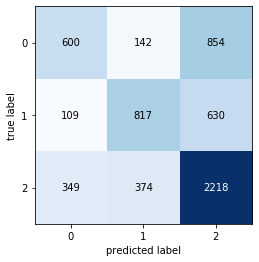

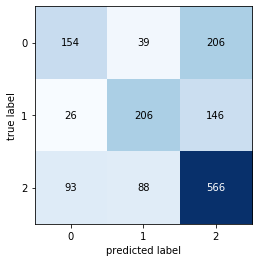

In [0]:
print('Training set Confusion Matrix')
print("-----------------------------")
print('Test set Confusion Matrix')

lr_cnf = confusion_matrix(y_train, lr_pred_train)
fig, ax = plot_confusion_matrix(conf_mat = lr_cnf)

lr_cnf = confusion_matrix(y_test, lr_pred_test)
fig, ax = plot_confusion_matrix(conf_mat = lr_cnf)

In [0]:
rf_params = {'n_estimators': [100, 500, 1000], 'criterion':['gini', 'entropy'], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5, 10]}
rf = RandomForestClassifier()
rf_op = GridSearchCV(rf, rf_params, cv = 5)

rf_op.fit(X_train, y_train)

print('Params for RandomforestClassifier grids: ',rf_op.cv_results_)

Params for RandomforestClassifier grids:  {'mean_fit_time': array([0.50062375, 2.44604959, 4.86797791, 0.43748884, 2.1665133 ,
       4.28783197, 0.37191076, 1.89355116, 3.72906361, 0.48823147,
       2.45342789, 4.88506598, 0.44058456, 2.14379396, 4.26988225,
       0.37174578, 1.85908875, 3.69676895, 0.54696383, 2.69165058,
       5.37978859, 0.47067647, 2.34459643, 4.70167394, 0.39947228,
       1.99771624, 4.01793356, 0.5454854 , 2.69316082, 5.46982269,
       0.53221998, 2.44883585, 4.75884199, 0.3992063 , 1.99444327,
       3.94384718]), 'std_fit_time': array([0.01409613, 0.01804015, 0.02109838, 0.00617201, 0.05661559,
       0.02647978, 0.00387954, 0.03720986, 0.02587478, 0.0056391 ,
       0.02717514, 0.02226282, 0.00819065, 0.01751631, 0.02262848,
       0.00607206, 0.01052663, 0.02189902, 0.00935454, 0.01441464,
       0.03778354, 0.0063891 , 0.03760418, 0.0850752 , 0.00676073,
       0.02982454, 0.01403701, 0.00592591, 0.02212122, 0.08509689,
       0.01200167, 0.08286445, 0

In [0]:
print('Best Params ', rf_op.best_params_)

print('Best RF GridsearchCV training accuracy: ', rf_op.best_score_)

Best Params  {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 500}
Best RF GridsearchCV training accuracy:  0.5869010238815903


In [0]:
rf = RandomForestClassifier(criterion='gini', n_estimators=500, max_features = 'sqrt', min_samples_split = 10, n_jobs= -1)

rf_op = rf.fit(X_train, y_train)

rf_pred_train = rf_op.predict(X_train)
rf_pred_test = rf_op.predict(X_test)

print("Accuracy Training set for RandomForest regression classifier = ", rf_op.score(X_train, y_train))
print("Accuracy Test set for RandomForest regression classifier = ", rf_op.score(X_test, y_test))

print("Accuracy for Optimized Training set for RandomForest regression classifier = ", accuracy_score(y_train, rf_pred_train))
print("Accuracy for Optimized Test set for RandomForest regression classifier = ", accuracy_score(y_test, rf_pred_test))
print('')

rfc = ensemble.RandomForestClassifier(criterion='entropy', n_estimators=500)
print(cross_val_score(rfc, X_train, y_train, cv = 5))
print(cross_val_score(rfc, X_test, y_test, cv = 5))
print('')

print('Training set classification report')
print(metrics.classification_report(y_train, rf_pred_train))

print('------------')

print('Test set classification report')
print(metrics.classification_report(y_test, rf_pred_test))

#overfitting

Accuracy Training set for RandomForest regression classifier =  0.8470375841129164
Accuracy Test set for RandomForest regression classifier =  0.5885826771653543
Accuracy for Optimized Training set for RandomForest regression classifier =  0.8470375841129164
Accuracy for Optimized Test set for RandomForest regression classifier =  0.5885826771653543

[0.57998359 0.59967186 0.5709598  0.57307061 0.57307061]
[0.5704918  0.57377049 0.54754098 0.6        0.55263158]

Training set classification report
              precision    recall  f1-score   support

           1       0.93      0.74      0.82      1596
           2       0.88      0.75      0.81      1556
           3       0.80      0.96      0.87      2941

    accuracy                           0.85      6093
   macro avg       0.87      0.82      0.84      6093
weighted avg       0.86      0.85      0.84      6093

------------
Test set classification report
              precision    recall  f1-score   support

           1     

Training set Confusion Matrix
-----------------------------
Test set Confusion Matrix


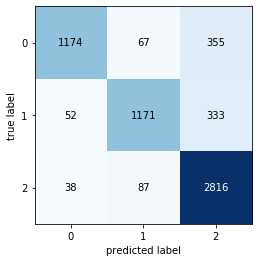

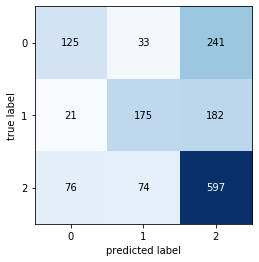

In [0]:
print('Training set Confusion Matrix')
print("-----------------------------")
print('Test set Confusion Matrix')

rf_cnf = confusion_matrix(y_train, rf_pred_train)
fig, ax = plot_confusion_matrix(conf_mat = rf_cnf)

rf_cnf = confusion_matrix(y_test, rf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat = rf_cnf)

In [0]:
svm_params = {'penalty': ['l1', 'l2'], "C": np.logspace(-1,1,10), "max_iter": [1000, 5000, 10000]}
svm = LinearSVC()
svm_op = GridSearchCV(svm, svm_params, cv = 5)
svm_op.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
        1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
                         'max_iter': [1000, 5000, 10000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
print('Accuracy for Linear SVC  Grids: {}',format(svm_op.cv_results_))

Accuracy for Linear SVC  Grids: {} {'mean_fit_time': array([5.04860878e-03, 7.78740883e-02, 3.61151695e-03, 6.40658379e-02,
       4.22039032e-03, 6.63063526e-02, 3.94701958e-03, 1.01373768e-01,
       4.11276817e-03, 1.06945992e-01, 4.07052040e-03, 1.30186987e-01,
       5.08956909e-03, 1.87406492e-01, 3.42912674e-03, 1.56959248e-01,
       3.63168716e-03, 1.66027260e-01, 3.56063843e-03, 2.65203905e-01,
       3.76214981e-03, 2.45422077e-01, 3.58819962e-03, 2.52770090e-01,
       3.70597839e-03, 5.09773207e-01, 3.73244286e-03, 4.72826004e-01,
       3.69119644e-03, 4.17017126e-01, 3.55758667e-03, 7.43981075e-01,
       3.75800133e-03, 8.43403959e-01, 3.53860855e-03, 8.73010254e-01,
       3.58681679e-03, 9.72025919e-01, 3.71556282e-03, 1.44175930e+00,
       3.59978676e-03, 1.45735159e+00, 3.82781029e-03, 1.03279529e+00,
       4.12888527e-03, 2.55833139e+00, 3.57527733e-03, 2.25683255e+00,
       3.60074043e-03, 1.01282601e+00, 3.62849236e-03, 4.10327363e+00,
       4.14457321e-03, 4

In [0]:
print('Best Params: ', svm_op.best_params_)
print('Best GridsearchCV training accuracy: ', svm_op.best_score_)

Best Params:  {'C': 0.16681005372000587, 'max_iter': 1000, 'penalty': 'l2'}
Best GridsearchCV training accuracy:  0.590015773784267


In [0]:
svm = LinearSVC(penalty = 'l2', C = 0.16681005372000587, max_iter = 1000)

svm_op_f = svm.fit(X_train, y_train)

svm_pred_train = svm_op_f.predict(X_train)
svm_pred_test = svm_op_f.predict(X_test)

print("Accuracy for Optimized Training Set of SVM classifier = ", accuracy_score(y_train, svm_pred_train) )
print("Accuracy for Optimized Test Set of SVM classifier = ", accuracy_score(y_test, svm_pred_test) )
print('')


print('Training set classification report')
print(metrics.classification_report(y_train, svm_pred_train))
print('------------')

print('Test set classification report')
print(metrics.classification_report(y_test, svm_pred_test))

Accuracy for Optimized Training Set of SVM classifier =  0.5982274741506647
Accuracy for Optimized Test Set of SVM classifier =  0.6023622047244095

Training set classification report
              precision    recall  f1-score   support

           1       0.57      0.37      0.45      1596
           2       0.61      0.53      0.57      1556
           3       0.60      0.75      0.67      2941

    accuracy                           0.60      6093
   macro avg       0.59      0.55      0.56      6093
weighted avg       0.60      0.60      0.59      6093

------------
Test set classification report
              precision    recall  f1-score   support

           1       0.55      0.37      0.45       399
           2       0.61      0.54      0.58       378
           3       0.61      0.76      0.68       747

    accuracy                           0.60      1524
   macro avg       0.59      0.56      0.57      1524
weighted avg       0.60      0.60      0.59      1524



Training set Confusion Matrix
-----------------------------
Test set Confusion Matrix


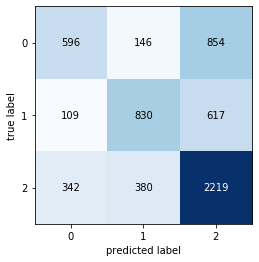

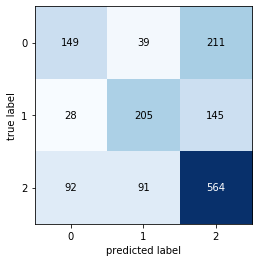

In [0]:
print('Training set Confusion Matrix')
print("-----------------------------")
print('Test set Confusion Matrix')

svm_cnf = confusion_matrix(y_train, svm_pred_train)
fig, ax = plot_confusion_matrix(conf_mat = svm_cnf)

svm_cnf = confusion_matrix(y_test, svm_pred_test)
fig, ax = plot_confusion_matrix(conf_mat = svm_cnf)

In [0]:
xgb_params = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1], 
    'max_depth': [4, 5, 6]}
xgb = XGBClassifier()
xgb_op = GridSearchCV(xgb, xgb_params, cv = 5)
xgb_op.fit(X_train, y_train)

print('Params for XGBoost grids: ',xgb_op.cv_results_)


Params for XGBoost grids:  {'mean_fit_time': array([ 0.72373567,  3.6694716 ,  7.54614239,  0.99194598,  4.74762535,
        9.5021944 ,  1.13805633,  5.78267965, 11.58841939,  0.75426798,
        3.79336929,  7.60974908,  0.94807348,  4.77079697, 10.4737246 ,
        1.16114545,  5.81796498, 11.60488186,  0.75732145,  3.8082582 ,
        7.5795517 ,  0.94873171,  4.8085927 ,  9.47435236,  1.18753324,
        8.6006197 , 14.09707022]), 'std_fit_time': array([0.03996043, 0.20146237, 0.05033286, 0.11642905, 0.05790898,
       0.14668144, 0.01343495, 0.07257355, 0.05771502, 0.00847751,
       0.03809373, 0.07569785, 0.00605162, 0.07714753, 1.05412432,
       0.01611773, 0.0706442 , 0.06209123, 0.00864431, 0.05985794,
       0.06339002, 0.01214735, 0.15088277, 0.01457317, 0.03079612,
       2.41800889, 3.19988468]), 'mean_score_time': array([0.00609679, 0.01868219, 0.03185148, 0.00763202, 0.02038813,
       0.04478717, 0.00777564, 0.02342997, 0.06216626, 0.00592871,
       0.01681967, 0.03

In [0]:
print('Best Params: ', xgb_op.best_params_)
print('Best GridsearchCV training accuracy: ', xgb_op.best_score_)

Best Params:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Best GridsearchCV training accuracy:  0.5859171492420906


In [0]:
xgb_op = XGBClassifier(learning_rate = 0.1, max_depth = 4, n_estimators = 100)
xgb_op.fit(X_train, y_train)

xgb_pred_op_train = xgb_op.predict(X_train)
xgb_pred_op_test = xgb_op.predict(X_test)

# print('XGBoost Optimized score: ', accuracy_score(y_test, xgb_pred_op))

# print(metrics.classification_report(y_test, xgb_pred))

print("Accuracy for Optimized Training Set of XGBoost classifier = ", accuracy_score(y_train, xgb_pred_op_train) )
print("Accuracy for Optimized Test Set of XGBoost classifier = ", accuracy_score(y_test, xgb_pred_op_test) )
print('')


print('Training set classification report')
print(metrics.classification_report(y_train, xgb_pred_op_train))
print('------------')

print('Test set classification report')
print(metrics.classification_report(y_test, xgb_pred_op_test))

Accuracy for Optimized Training Set of XGBoost classifier =  0.6605941244050549
Accuracy for Optimized Test Set of XGBoost classifier =  0.6010498687664042

Training set classification report
              precision    recall  f1-score   support

           1       0.66      0.46      0.54      1596
           2       0.69      0.58      0.63      1556
           3       0.65      0.81      0.72      2941

    accuracy                           0.66      6093
   macro avg       0.67      0.62      0.63      6093
weighted avg       0.66      0.66      0.65      6093

------------
Test set classification report
              precision    recall  f1-score   support

           1       0.53      0.37      0.44       399
           2       0.64      0.52      0.58       378
           3       0.61      0.76      0.68       747

    accuracy                           0.60      1524
   macro avg       0.59      0.55      0.56      1524
weighted avg       0.60      0.60      0.59      1524



Training set Confusion Matrix
-----------------------------
Test set Confusion Matrix


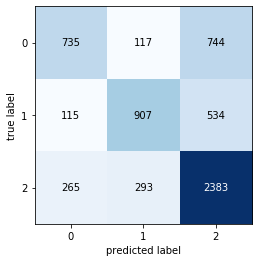

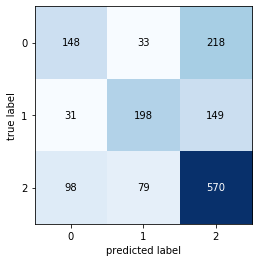

In [0]:
print('Training set Confusion Matrix')
print("-----------------------------")
print('Test set Confusion Matrix')

xgb_cnf = confusion_matrix(y_train, xgb_pred_op_train)
fig, ax = plot_confusion_matrix(conf_mat = xgb_cnf)

xgb_cnf = confusion_matrix(y_test, xgb_pred_op_test)
fig, ax = plot_confusion_matrix(conf_mat = xgb_cnf)

# Results

## First, a quick recap from the original untuned models (feature importance modifications applied):

LinearRegression:

Training set Accuracy for logistic regression classifier =  0.6010175611357296 //
Test set Accuracy for logistic regression classifier =  0.5853018372703412

RandomForest:

Accuracy Training set for RandomForest regression classifier =  1.0 //
Accuracy Test set for RandomForest regression classifier =  0.5912073490813649

SVM:

Accuracy for Training Set of SVM classifier =  0.6001969473165928 //
Accuracy for Test Set of SVM classifier =  0.583989501312336


XGBoost:

Accuracy for Training Set of XGBoost classifier =  0.970786148038733 //
Accuracy for Test Set of XGBoost classifier =  0.5498687664041995


## And, after hyperparameter tuning:

Linear Regression: 

Training set Accuracy for optimized logistic regression classifier =  0.5965862465123912 //
Test set Accuracy for optimized logistic regression classifier =  0.6076115485564304

RandomForest: 

Accuracy for Optimized Training set for RandomForest regression classifier =  0.8470375841129164 //
Accuracy for Optimized Test set for RandomForest regression classifier =  0.5885826771653543

(Overfitting is evident here. With more adjustments done to added hyperparameters, or different feature importance mods, we can probably fix this.)

SVM: 

Accuracy for Optimized Training Set of SVM classifier =  0.5982274741506647 //
Accuracy for Optimized Test Set of SVM classifier =  0.6023622047244095

XGBoost: 

Accuracy for Optimized Training Set of XGBoost classifier =  0.6605941244050549 //
Accuracy for Optimized Test Set of XGBoost classifier =  0.6010498687664042




There are some marked increases in accuracy of about 1 - 2% per model. At this point it seems that LinearRegression or SVM is the most effective here. However, XGBoost does come in a very close 3rd. Randomforest may do better if we go back and tune to avoid overfitting. However, that is something that could be done in a later iteration of this study.

Looking at the confusion matrix, we can gather that prediction power is greater for the Republican and Independent/Other parties, however scores dip greatly when looking at Democrats. This could be due to a lot of similarities in the data between inmates who identify with Democrats and those who support other parties.


# Supplementary Materials 1 - Leaving "Independent" and "Other" in the dataset as they are and performing analysis

I decided not to include this model, as there were performance issues. I will not be performing the amount of analysis as I did above, but simply showing the vanilla models and how they perform. There will be serious differences in how they perform even at the lowest level without any tuning.



In [0]:
test2 = df
test2 = test2.drop('state', 1)
non_numeric_2 = test2.select_dtypes('object').columns
non_numeric_2 = non_numeric_2.drop(['how_get_news', 'who_vote_for', 'approve_disapprove_trump', 'party', 'which_party_for_cj_reform'])

test2 = pd.concat([test2, pd.get_dummies(test[non_numeric])], axis = 1)

test2 = test2[test2['party'].notna()]

test2['party_y'] = test2['party'].replace(['Independent', 'Other', 'The Democratic party',
       'The Republican party'], [3, 4, 1, 2])

numeric_rows_2 = test2.select_dtypes(['int64', 'uint8']).columns
numeric_rows_2 = numeric_rows_2.drop(['party_y'], 1)

X = test2[numeric_rows]
y = test2['party_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr_2 = LogisticRegression(solver = 'lbfgs', max_iter = 10000)
lr_2.fit(X_train, y_train)

print("Accuracy for logistic regression classifier = ", lr_2.score(X_test, y_test) )

from sklearn import metrics
lr_2_pred = lr_2.predict(X_test)
print(metrics.classification_report(y_test, lr_2_pred))

Accuracy for logistic regression classifier =  0.4757217847769029
              precision    recall  f1-score   support

           1       0.49      0.55      0.52       393
           2       0.56      0.62      0.59       383
           3       0.38      0.42      0.40       442
           4       0.50      0.29      0.37       306

    accuracy                           0.48      1524
   macro avg       0.48      0.47      0.47      1524
weighted avg       0.48      0.48      0.47      1524



In [0]:
rf_2 = RandomForestClassifier(max_depth = 5)
rf_2.fit(X_train, y_train)
print("Accuracy for RandomForest regression classifier = ", rf_2.score(X_test, y_test) )
rfc_2 = ensemble.RandomForestClassifier()
print(cross_val_score(rfc_2, X_train, y_train, cv = 10))

Accuracy for RandomForest regression classifier =  0.4540682414698163
[0.47868852 0.42786885 0.48032787 0.45484401 0.48111658 0.42692939
 0.4499179  0.47126437 0.43349754 0.48604269]


In [0]:
rf_2_pred = rf_2.predict(X_test)
print(metrics.classification_report(y_test, rf_2_pred))

              precision    recall  f1-score   support

           1       0.48      0.52      0.50       393
           2       0.53      0.62      0.57       383
           3       0.37      0.50      0.43       442
           4       0.49      0.09      0.15       306

    accuracy                           0.45      1524
   macro avg       0.47      0.43      0.41      1524
weighted avg       0.46      0.45      0.43      1524



In [0]:
svm_2 = LinearSVC(penalty='l1', dual=False)

svm_2.fit(X_train, y_train)
print("Accuracy for SVM classifier = ", svm_2.score(X_test, y_test) )

svm_2_pred = svm_2.predict(X_test)
print(metrics.classification_report(y_test, svm_2_pred))

Accuracy for SVM classifier =  0.46653543307086615
              precision    recall  f1-score   support

           1       0.48      0.57      0.52       393
           2       0.53      0.65      0.58       383
           3       0.36      0.35      0.36       442
           4       0.51      0.27      0.35       306

    accuracy                           0.47      1524
   macro avg       0.47      0.46      0.45      1524
weighted avg       0.46      0.47      0.46      1524



In [0]:
xgb_2 = XGBClassifier()
xgb_2.fit(X_train, y_train)

print("Accuracy for XGBoost classifier = ", xgb_2.score(X_test, y_test) )

xgb_2_pred = xgb_2.predict(X_test)
print(metrics.classification_report(y_test, xgb_2_pred))

Accuracy for XGBoost classifier =  0.42979002624671914
              precision    recall  f1-score   support

           1       0.44      0.47      0.45       393
           2       0.52      0.55      0.53       383
           3       0.35      0.38      0.36       442
           4       0.42      0.31      0.36       306

    accuracy                           0.43      1524
   macro avg       0.43      0.43      0.43      1524
weighted avg       0.43      0.43      0.43      1524



So, we are seeing much lower model performance.

LinearRegression: 0.4757217847769029, RandomForest: 0.4540682414698163, LinearSVC: 0.46653543307086615, XGBoost: 0.42979002624671914

Even if we saw the amount of jump in performance as before, it would still be less than combining Independent and "Other" voters.

There are many ways we could explain this: Possibly there is too much variation in the Independent and Other voter database, and that is causing the models to lose predictive power.

# Supplementary Materials 2: Completely cutting out both Independent and Other Voters and measuring only the two main parties

There is no reason you should do this, as independent voters and "other" voters make up so much of the original demographic. However, if you were interested in only bi-partisan politics, there could be a case for cutting anyone who might have a divergent political opinion.

Again, I am doing this to look at the dataset from a different angle. I will not perform an extremely exhaustive analysis like the one I did above, but rather show model performance at the vanilla (untuned) level.

In [0]:
test3 = df
test3 = test3.drop('state', 1)
non_numeric_3 = test2.select_dtypes('object').columns
non_numeric_3 = non_numeric_3.drop(['how_get_news', 'who_vote_for', 'approve_disapprove_trump', 'party', 'which_party_for_cj_reform'])

test3 = pd.concat([test3, pd.get_dummies(test[non_numeric])], axis = 1)

test3 = test3[test3['party'].notna()]

test3 = test3[test3['party'] != 'Independent']
test3 = test3[test3['party'] != 'Other']

In [0]:
test3['party_y'] = test3['party'].replace(['The Democratic party',
       'The Republican party'], [1, 2])

In [0]:
numeric_rows_3 = test3.select_dtypes(['int64', 'uint8']).columns
numeric_rows_3 = numeric_rows_3.drop(['party_y'], 1)

X = test3[numeric_rows]
y = test3['party_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr_3 = LogisticRegression(solver = 'lbfgs', max_iter = 10000)
lr_3.fit(X_train, y_train)

print("Accuracy for logistic regression classifier = ", lr_3.score(X_test, y_test) )

from sklearn import metrics
lr_3_pred = lr_3.predict(X_test)
print(metrics.classification_report(y_test, lr_3_pred))

Accuracy for logistic regression classifier =  0.7811704834605598
              precision    recall  f1-score   support

           1       0.78      0.80      0.79       409
           2       0.78      0.76      0.77       377

    accuracy                           0.78       786
   macro avg       0.78      0.78      0.78       786
weighted avg       0.78      0.78      0.78       786



In [0]:
rf_3 = RandomForestClassifier(max_depth = 5)
rf_3.fit(X_train, y_train)
print("Accuracy for RandomForest regression classifier = ", rf_3.score(X_test, y_test) )
rfc_3 = ensemble.RandomForestClassifier()
print(cross_val_score(rfc_3, X_train, y_train, cv = 10))

rf_3_pred = rf_3.predict(X_test)
print(metrics.classification_report(y_test, rf_3_pred))

Accuracy for RandomForest regression classifier =  0.7544529262086515
[0.75555556 0.82539683 0.76507937 0.77070064 0.75477707 0.77388535
 0.76751592 0.78980892 0.76751592 0.71974522]
              precision    recall  f1-score   support

           1       0.76      0.77      0.77       409
           2       0.75      0.73      0.74       377

    accuracy                           0.75       786
   macro avg       0.75      0.75      0.75       786
weighted avg       0.75      0.75      0.75       786



In [0]:
svm_3 = LinearSVC(penalty='l1', dual=False)

svm_3.fit(X_train, y_train)
print("Accuracy for SVM classifier = ", svm_3.score(X_test, y_test) )

svm_3_pred = svm_3.predict(X_test)
print(metrics.classification_report(y_test, svm_3_pred))

Accuracy for SVM classifier =  0.77735368956743
              precision    recall  f1-score   support

           1       0.78      0.80      0.79       409
           2       0.78      0.75      0.76       377

    accuracy                           0.78       786
   macro avg       0.78      0.78      0.78       786
weighted avg       0.78      0.78      0.78       786



In [0]:
xgb_3 = XGBClassifier()
xgb_3.fit(X_train, y_train)

print("Accuracy for XGBoost classifier = ", xgb_3.score(X_test, y_test) )

xgb_3_pred = xgb_3.predict(X_test)
print(metrics.classification_report(y_test, xgb_3_pred))

Accuracy for XGBoost classifier =  0.7493638676844784
              precision    recall  f1-score   support

           1       0.76      0.76      0.76       409
           2       0.74      0.73      0.74       377

    accuracy                           0.75       786
   macro avg       0.75      0.75      0.75       786
weighted avg       0.75      0.75      0.75       786



So, we are seeing much HIGHER model performance now.

LinearRegression:  0.7811704834605598, RandomForest: 0.7544529262086515, LinearSVC:0.77735368956743, XGBoost: 0.7493638676844784

So, if we were only look at Democratic and Republican parties, this survey quite a good instrument to predict if an inmate will be voting either Democratic or Republican. However, you completely cut out and ignore anyone who might have thought to answer "Independent" or other parties. Realistically, this wouldn't fly as there are more than just Democratic and Republican voters in the US (though you wouldn't know by reading the news). 

# Suggestions for further research and areas of improvement

First, I will start with a short list of things that could have been done differently:
    - Principal components could have been made to represent that areas of high multicolinearity. This would mainly encompass the identity areas.
    - I could have attempted to re-do the Randomforest classifiers with only textual data (and not used the dummies)
    - While it may have changed the data as a whole, performing interpolation with mode imputation on the "state" feature that was dropped may have affected scores in some way.
    - Feature importance cutting may have been handled a little better. Features near the bottom could have been cobbled together into a principal component to avoid losing any of the information that was included in those columns.
    - Rather than using GridSearchCV, more granular analysis of each hyperparameter could have been done to ascertain the absolute best hyperparameters for each.
    - More hyperparameters could have been included in GridSearchCV. In order to save time and not melt my PC, I only included 3-4 for each model.
    - There are some areas which needs more consideration: some training test scores were extremely high and I'm still not entirely sure how that happened.
    - The current model may have been affected by the difference in data points between Democratic/Republican and independent/other. There were almost 2x as many independent/other than either Democratic or Republican. If the data points were equal or normalized it may increase accuracy or model performance.
    - Related to the above point, splitting the train/test group between 0.1 to 0.5 may reveal much more information about how the model is performing.
    
    
Lastly, Suggestions for further research:
    - A dataset like this would have definitely benefitted from having much more granular results: 
               - Specific age instead of categories of age
               - More political parties than "other" and "independent"
               - Specific number of years in the institution
               - A birthdate column?
               - More States need to be reported. That could have added quite a lot of information for the analysis
               - Political party analysis done on former-inmates as well
               - Focus on battleground states (Ohio, Florida, etc). 

# So, what does this mean?

There are currently 2.3 million prison inmates in the US.
Inmates are not allowed to vote, but each year, 650,000 are released from federal prisons. This consitutes a large amount of potential voters.
This is especially important when you begin to consider battleground states and how close the vote comes down to in those states.
There are currently not too many programs which attempt to sway or fight for the former-inmate vote. This is a large opportunity which is being lost and could help boost political gain in the US.

A data analysis such as this would be extremely beneficial to those looking to capitalize on thus-far untapped possible voters.

According to the data that has been presented here, a model which has been trained on the Marshall Project Data has a 60% accuracy rating to predict unseen data. However, the accuracy rating falls when we try to predict inmates who would identify with Democrats.